In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle

C:\Users\andre\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Cose da testare:

- a che numero secondi tagliare ogni audio
- spectogramma in dB o normale
- mfcc
- anzichè droppare tutti i segnali lunghi tagliare porzioni utili di audio lunghi 20 secondi ed aggiungerle a segnali audio brevi
- numero righe e colonne su cui splittare spectogramma
- applicare eventuale denoising 

### Results
- **Configuration**: <= 4 secondi, spettogramma normale, width_col = 30, width_row = 32 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50} <br/>
 **accuracy** = 0.43521102951171653 <br/>
 
 - **Configuration**: <= 4 secondi, spettogramma dB, width_col = 30, width_row = 32 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100} <br/>
 **accuracy** = 0.41 <br/>
 
  - **Configuration**: <= 4 secondi, spettogramma dB, width_col = 10, width_row = 16 <br/>
  **best hyperparams**: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100} <br/>
 **accuracy** =  0.45912102696730256 <br/>
 
   - **Configuration**: <= 2.64 secondi, spettogramma dB, width_col = 10, width_row = 16 <br/>
  **best hyperparams**:  {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100} <br/>
 **accuracy** =  0.458447821855859 <br/>
 
 




## 1. Loading Dataset

In [2]:
path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'
df_development = pd.read_csv(path)
df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


In [3]:
#Evlauate balancement of dataset
df_development.action.value_counts(), df_development.object.value_counts()

(increase           3823
 decrease           3575
 change language    1113
 activate            791
 deactivate          552
 Name: action, dtype: int64,
 volume    5000
 heat      2398
 none      1113
 music      791
 lights     552
 Name: object, dtype: int64)

### Evaluate all the existing combinations in the dataset

In [4]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [5]:
df_increase

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
6,6,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/6a1cd...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
7,7,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/72160...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
16,16,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/256b2...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9829,9829,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/37824...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40
9837,9837,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/98546...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9838,9838,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/a1b55...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9842,9842,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/1e8a9...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40


In [6]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [7]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [8]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [9]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### Creating new training dataset
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=increase and object=heat has label 1)

In [10]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']=1
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']=2

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']=3
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']=4

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']=5

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']=6
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']=7

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,6
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,7
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,3
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7


Now to generate a new dataset with recording and corresponding label assigned we need to extract every audio file looking ath the path column

In [11]:
path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_development['path']

In [12]:
# signals = []
# sample_rates = []

# for path in paths_recordings:
#     file_path = f'{path_working_directory}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)
#     sample_rates.append(sr)
    

In [13]:
# labels = df_development['labels']
# df = []
# df.append(paths_recordings)
# df.append(signals)
# df.append(sample_rates)
# df.append(labels)

In [14]:
# df=[]
# name_file = r'/df.pickle'
# print( path_working_directory+name_file)
# with open(path_working_directory+name_file, "wb") as output_file:
#     pickle.dump(df, output_file)

In [15]:
name_file = r'/df.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df = pickle.load(f)
#df


<AxesSubplot:>

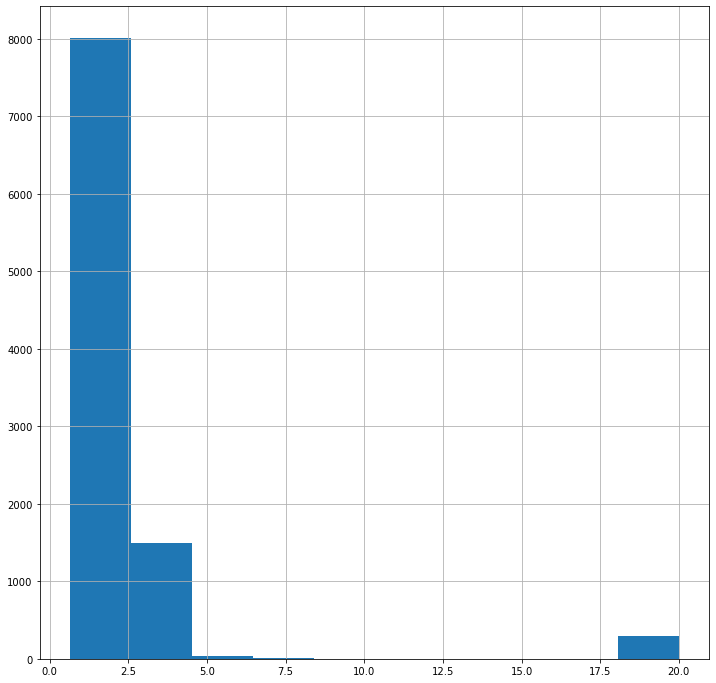

In [16]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr  <=4:
        indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
length_audios_seconds.hist()
#print(length_audios_seconds)


In [17]:
np.array(length_audios_seconds).mean()

2.6398029599499635

In [18]:
len(indexes)

9464

In [19]:
# length_audios = []
# length_audios_seconds = []
# indexes_to_drop = []
# i = 0

# for item,sr in zip(df[1], df[2]):
#     length_audios.append(len(item))
#     length_audios_seconds.append(len(item)/sr)
#     if len(item)/sr >= 4 and len(item)/sr <= 4.2:
#         indexes_to_drop.append(i)
#     i = i+1

In [20]:
# indexes_to_drop

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

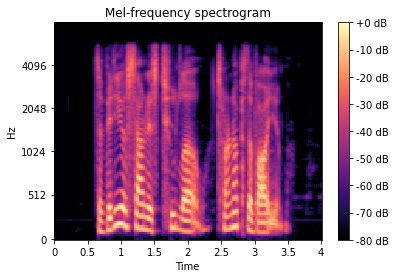

In [21]:
spectogram = librosa.feature.melspectrogram(y=df[1][1752], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [22]:
S_dB

array([[-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       ...,
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32)

In [23]:
spectogram.shape

(128, 173)

In [24]:
s_rates = pd.Series(df[2])
s_rates.value_counts()

22050    9854
dtype: int64

Every signal has the same sample rate of 22050.

In [25]:
sample_rate = 22050

In [26]:
indexes

length_audios_seconds[7767] #8140, 8228]
#print(length_audios_seconds.value_counts().iloc[:50])
length_audios_seconds.value_counts().iloc[:50].keys().drop(20).max()
length_audios_seconds.value_counts().iloc[:50].values.sum()
#[1752, 3671, 4234, 4675, 5669, 7111, 7767, 7843, 8888]

# cnt = 0
# for i in length_audios_seconds.value_counts().keys():
    
#     if i >=4.95 and i <=5.05:
#         print(i)
#         print(cnt)
#     cnt = cnt+1

9472

## 2. Pre-Processing

There exist 9464 audio files (-300 of 20 seconds long) whose length is below 4 seconds, since the total of samples is 9857, it seems reasonable to cut take only the files whose length is lower or equal to 4 and then, in order to obtain comparable spectogram matrixes for every audio signal, the signals that present length < 4 are zero padded in the end in order to reach all audio signal of the same length (4) so also the matrices will be of the same size.

In [27]:
length_audios = []
length_audios_seconds = []
indexes_to_drop = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr > 2.64:
        indexes_to_drop.append(i)
    i = i+1
        



In [28]:
len(indexes_to_drop)

1761

In [29]:
df_pd = pd.DataFrame({'audio':df[1], 'label':df[3]})
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",3
9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",7
9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",7
9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",7


In [30]:
df_pd=df_pd.drop(indexes_to_drop).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
8088,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
8089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
8090,"[0.0014619534, 0.0017252679, 0.0015617849, 0.0...",7
8091,"[0.009850104, 0.011306311, 0.009458789, 0.0098...",5


Now retireve the max length of samples characterizing audio file (should be around 4 seconds) in order to pad every other array with lower dimension til the same length in order to have all audio file of the same length.

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

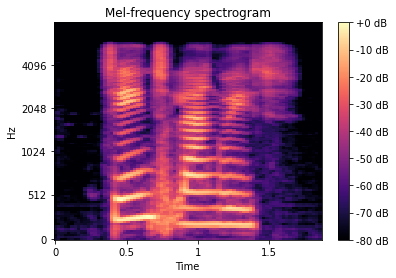

In [31]:
spectogram = librosa.feature.melspectrogram(y=df[1][0], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [32]:
# spectogram = librosa.feature.melspectrogram(y=np.pad(df_pd.audio[0],(0,88064- len(df_pd.audio[9463])),mode='constant', constant_values=0), sr=sr)

# fig, ax = plt.subplots()
# S_dB = librosa.power_to_db(spectogram, ref=np.max)
# img = librosa.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=sr,
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')

In [33]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio]
# idx = 45 #check
# lengths[idx], len(df_pd.audio.iloc[idx])
lengths = pd.Series(lengths)
#lengths.max() #88064
lengths[lengths == lengths.max()]

2411    57390
dtype: int64

In [34]:
# def pad_audio(audio, max_length):
#     t = max_length - len(audio)
#     return np.pad(audio, pad_width=(0, t), mode='constant')

In [35]:
max_length = lengths.max()
for i, audio in enumerate(df_pd.audio):
    
    #print(len(df_pd.audio[i]))
    #audio_padded = np.resize(df_pd.audio[i], max_length)
    df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)
    
    #print(len(df_pd.audio[i]))
#     if i == 2:
#         break

C:\Users\andre\AppData\Local\Temp/ipykernel_8104/27520399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)


In [36]:
lengths = [len(audio) for audio in df_pd.audio]
lengths = pd.Series(lengths)
lengths.value_counts()

57390    8093
dtype: int64

Test if audio has been correctly padded by checking if black background has been added on the right of the image

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

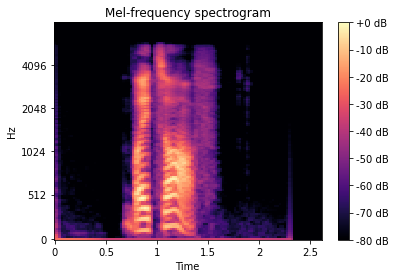

In [37]:
spectogram = librosa.feature.melspectrogram(y=df_pd.audio[8092], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


In [38]:
S_dB.shape

(128, 113)

In [39]:
#Find the first number which can be divided by 10
n = S_dB.shape[1]

while n % 10 != 0:
    n = n+1
n

120

Now that every audio signal has the same size and been correctly padded we can compute the spectogram matrix for each of them

In [40]:
spectograms = []

#Flag variable to indicate if we take the dB scale or not of the spectograms
dB = True

if dB == True:
    tmp = np.full((spectogram.shape[0], n-spectogram.shape[1]), -80.0)
else:
    #the sprectograms obtained for these audios are 128x173 so we add 7 columns of 0 to get 128x180 matrices (<=4 seconds)
    tmp = np.zeros((spectogram.shape[0], n-spectogram.shape[1]))

print(tmp.shape)



for i, audio in enumerate(df_pd.audio):
    spectogram = librosa.feature.melspectrogram(y=df_pd.audio[i], sr=sr)
    
    if dB == True:
        spectogram = librosa.power_to_db(spectogram, ref=np.max)
    
    #adjust spectogram size to get nice number of columns that are easy to divide3
    spectogram= np.hstack((spectogram,tmp))
    
    spectograms.append(spectogram)


(128, 7)


In [41]:
# x= spectograms[0].copy()
# tmp = np.zeros((spectograms[0].shape[0], 7))
# x=np.hstack((x,tmp))
# x.shape

In [42]:
df_pd['spectogram'] = spectograms

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

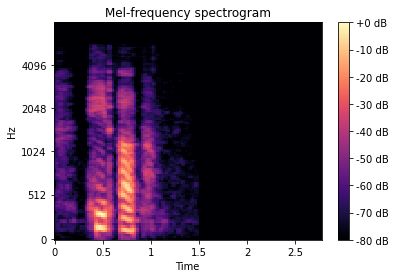

In [43]:
fig, ax = plt.subplots()
img = librosa.display.specshow(df_pd.spectogram[467], x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Now that we have obtained the spectogram of same dimension for every audio signal we can procede with the step of feature extraction.

## 3. Feature Extraction

For each spectogram of dimension RxC we need to divide it into a grid of rxc squares, each square will have dimensions R/r and C/c, so r and c will be hyperparameters.

Let's start by choosing r = c.

In [44]:
R, C = df_pd.spectogram[0].shape
width_row =  8 #128/8 = 16 -> each square will have height of 16
width_col = 5 #173/8 = 21.625 -> each square has width of 21.625 

In [45]:
R, C

(128, 120)

In [46]:
import numpy as np 

# Define the number of rows and columns for each submatrix 
rows = width_row 
cols = width_col
#df_means_stds = pd
#for audio_spectogram in df_pd.spectogram:
    
data = []


for audio_spectogram in df_pd.spectogram:
    
    means = []
    stds = []

    # Define the original matrix 
    original_matrix = audio_spectogram

    # Divide the original matrix into submatrices 
    submatrices = np.array([original_matrix[i:i+rows, j:j+cols] for i in range(0, original_matrix.shape[0], rows) for j in range(0, original_matrix.shape[1], cols)]) 

    for sub in submatrices:
        means.append(sub.mean())
        stds.append(sub.std())
    
    row_to_add = means + stds
    data.append(row_to_add)

submatrices.shape


(384, 8, 5)

In [47]:
new_df = pd.DataFrame(data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-73.022164,-71.308491,-65.822394,-46.530535,-48.471708,-46.364457,-31.504308,-38.696398,-43.336273,-43.993838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-72.664091,-71.988889,-49.272100,-39.120044,-43.484315,-38.472448,-40.839720,-41.279357,-43.348104,-45.279856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-61.294767,-62.507754,-61.199360,-61.178965,-38.458587,-48.541965,-44.755569,-31.105228,-31.421016,-34.004389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-78.080552,-76.672020,-77.465777,-65.246308,-49.952643,-51.919904,-50.444346,-50.028138,-47.922607,-45.372180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-63.528118,-60.316970,-72.745985,-74.567399,-75.903294,-64.334842,-56.418834,-48.476740,-46.054941,-47.867169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,-50.998999,-46.378731,-43.974388,-38.544809,-37.654010,-34.215519,-32.069736,-41.066591,-39.522629,-40.708092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8089,-51.390495,-51.871110,-43.113026,-33.598397,-41.230676,-39.155377,-40.827083,-42.086842,-42.040827,-42.139215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8090,-47.105641,-58.048763,-58.056323,-35.272227,-27.189742,-29.973983,-40.802237,-39.414842,-35.877473,-30.849134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8091,-47.449036,-57.101378,-57.558217,-59.246455,-61.950027,-45.412483,-25.824141,-25.477686,-36.565692,-33.257884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
new_df['label'] = df_pd.label
new_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-73.022164,-71.308491,-65.822394,-46.530535,-48.471708,-46.364457,-31.504308,-38.696398,-43.336273,-43.993838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,-72.664091,-71.988889,-49.272100,-39.120044,-43.484315,-38.472448,-40.839720,-41.279357,-43.348104,-45.279856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,-61.294767,-62.507754,-61.199360,-61.178965,-38.458587,-48.541965,-44.755569,-31.105228,-31.421016,-34.004389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,-78.080552,-76.672020,-77.465777,-65.246308,-49.952643,-51.919904,-50.444346,-50.028138,-47.922607,-45.372180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-63.528118,-60.316970,-72.745985,-74.567399,-75.903294,-64.334842,-56.418834,-48.476740,-46.054941,-47.867169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,-50.998999,-46.378731,-43.974388,-38.544809,-37.654010,-34.215519,-32.069736,-41.066591,-39.522629,-40.708092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
8089,-51.390495,-51.871110,-43.113026,-33.598397,-41.230676,-39.155377,-40.827083,-42.086842,-42.040827,-42.139215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
8090,-47.105641,-58.048763,-58.056323,-35.272227,-27.189742,-29.973983,-40.802237,-39.414842,-35.877473,-30.849134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
8091,-47.449036,-57.101378,-57.558217,-59.246455,-61.950027,-45.412483,-25.824141,-25.477686,-36.565692,-33.257884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [49]:
#Check that mean and std are computed correctly
means = []
stds = []

# Define the original matrix 
original_matrix = df_pd.spectogram[0]

# Divide the original matrix into submatrices 
submatrices = np.array([original_matrix[i:i+rows, j:j+cols] for i in range(0, original_matrix.shape[0], rows) for j in range(0, original_matrix.shape[1], cols)]) 

for sub in submatrices:
    means.append(sub.mean())
    stds.append(sub.std())

row_to_add = means + stds
#row_to_add
means

[-73.02216396331787,
 -71.30849132537841,
 -65.82239437103271,
 -46.53053464889526,
 -48.47170848846436,
 -46.36445660591126,
 -31.50430793762207,
 -38.69639761447907,
 -43.33627324104309,
 -43.99383767843246,
 -41.45667996406555,
 -37.246152794361116,
 -54.56770851612091,
 -61.85502758026123,
 -65.74084548950195,
 -69.00695390701294,
 -77.79952259063721,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -76.8404462814331,
 -76.65277862548828,
 -71.50990877151489,
 -36.38989056348801,
 -31.567150628566743,
 -26.142123818397522,
 -22.637029683589937,
 -24.10811355113983,
 -37.38747236728668,
 -37.20050783157349,
 -33.773241341114044,
 -32.21191862821579,
 -55.555833196640016,
 -66.8601586341858,
 -70.1753306388855,
 -73.55306282043458,
 -79.42338943481445,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -77.54244556427003,
 -77.25712337493897,
 -65.57974834442139,
 -38.351199340820315,
 -29.322234177589415,
 -33.08113672733307,
 -27.26964635848999,
 -25.32327046394348,
 

## 4. Training and Validation

In [50]:
y = new_df['label']
X = new_df.drop(columns='label')
seed = 42

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((6474, 768), (1619, 768), (6474,), (1619,))

In [52]:
### RandomForest Regression ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[50, 100], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results

best_params, RF_CV_results = randforest_classifier(X_train, y_train, 10, seed)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


KeyboardInterrupt: 

In [ ]:
best_params

## Esperimenti a caso

In [ ]:
# frame = 1024
# hop = frame//2 #integer division


In [ ]:
# df[2]
# s_rate=pd.Series(df[2])
# s_rate.value_counts()

for item,sr in zip(df[1], df[2]):
    print(item, sr)
    break

In [ ]:
index = 23#34#1#36#126        
#length_audios[length_audios==150000]
df[1][index]
print(df[3][index])
print(len(df[1][index]))
path_audio = df_development.path[index]
path_working_directory+'/'+path_audio
ipd.Audio(path_working_directory+'/'+path_audio)

In [ ]:
length_audios.loc[(length_audios<=50000)]# & (length_audios<=100000)]


In [ ]:
df[1][1]

In [ ]:
len(indexes)

Trying to visualize signals of different classes to see if there exist common patterns.

In [ ]:
df_development[df_development['labels']==5].head()

In [ ]:
# index, label
#3,  1
#4,  1
#6,  2
#7,  2
#5,  3
#26, 3
#8,  4
#9,  4
#0,  5
#47, 5
#1,  6
#12, 6
#2,  7
#15, 7
plt.figure(figsize=(10, 12))

plt.subplot(3,1,1)
librosa.display.waveshow(df[1][8140], alpha=0.5)
plt.subplot(3,1,2)
librosa.display.waveshow(df[1][15], alpha=0.5)

# x = np.linspace(0, 10 - 2 * delta, 200) + delta
# fig, axs = plt.subplots(3, 7, figsize=(15,30), constrained_layout=True)
# for ax in axs:
#     ax.plot(x,df[1][3])

# plt.subplot(3,2,1)
# librosa.display.waveshow(df[1][6], alpha=0.5)
# plt.subplot(3,2,2)
# librosa.display.waveshow(df[1][7], alpha=0.5)
# small_df = []
# small_df.append(df[1][4])
# small_df

## 3.  Feature Extraction

In [ ]:
spectogram = librosa.feature.melspectrogram(y=df[1][36], sr=sr)
spectogram.shape

In [ ]:
spectogram = librosa.feature.melspectrogram(y=df[1][8140], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
df_spectogram = pd.DataFrame(spectogram)
df_spectogram.shape



In [ ]:
def compute_mean_std_spectogram(spectogram, R, C):
    
    
    
    for i in range(len(R)):
        for j in range(len(C)):
            

## 4. Classification